# Electrical circuit analysis

[Skip the code](#start)

In [2]:
from typing import List, Tuple
import networkx as nx
from random import random
def load_weighted_graph(name: str) -> Tuple[int, List]:
    """Load a graph in the DIMACS ascii format (with weights) from
     the file "name" and return it as a list of sets
     Returns (V,L)
     V -- number of vertices (1, ..., V)
     L -- list of edges in the format (x,y,w): edge between x and y with weight w (x<y)"""

    V = 0
    L = []

    f = open(name, "r")
    lines = f.readlines()
    for l in lines:
        s = l.split()
        if len(s) < 1: continue
        if s[0] == "c":
            continue
        elif s[0] == "p":
            V = int(s[2])
        elif s[0] == "e":
            (a, b, c) = (int(s[1]), int(s[2]), int(s[3]))
            (x, y, c) = (min(a, b), max(a, b), c)
            L.append((x, y, c))

    f.close()
    return V, L

def toNxGraph0(name: str):
    V, L = load_weighted_graph(name)
    G = nx.Graph()
    G.add_nodes_from([x for x in range(0, V)])
    for (u, v, weight) in L:
        G.add_edge(u-1, v-1, weight=weight, current=0)
    nx.set_node_attributes(G, None, 'V')
    nx.set_node_attributes(G, '#dabb69', 'color')
    return G

def add_attr(G: nx.Graph):
    nx.set_edge_attributes(G, 0, 'weight')
    for (u, v) in G.edges():
        G[u][v]['weight'] = random()*20
    nx.set_node_attributes(G, None, 'V')
    nx.set_node_attributes(G, '#dabb69', 'color')


In [3]:
def normalize(idx, shape=None):
    if(shape is None or len(shape)==1):
        return idx
    if len(shape)==2:
        return idx[0]*shape[1]+idx[1]
    

In [4]:
import numpy as np
import networkx as nx

""" finds voltages on each node calculated using node analysis method 
@shape: index labels dimensions( ex (5,6) for 2d graph, (30)(or None) for classic ) """
def node_analysisNx(G: nx.Graph, shape=None):
    A = np.zeros(shape=(len(G), len(G)))
    B = np.array([0]*len(G))
    ns = G.nodes
    for idx in ns:
        idx_norm = normalize(idx, shape)  # if dx is not a single nr (e.g. 2dgrid->(0,1))
        if ns[idx]['V'] is not None:
            A[idx_norm][idx_norm] = 1
            B[idx_norm] = ns[idx]['V']
        else:
            for neigh in G[idx]:  # neigh = (v_idx, edge_weight)
                w = G[idx][neigh]['weight']
                A[idx_norm][idx_norm] += 1./w
                A[idx_norm][normalize(neigh, shape)] -= 1./w
    Vs = np.linalg.solve(A, B)
    for idx in ns:
        ns[idx]['V'] = Vs[normalize(idx, shape)]


In [5]:
""" update current for each edge (in undirected graph)"""
def update_current(G: nx.Graph):
    for (u, v, props) in G.edges(data=True):
        props['current'] = abs(G.nodes[u]['V']-G.nodes[v]['V'])/props['weight']



In [12]:
def build_directed(G: nx.Graph, with_voltage=True):
    """ build directed graph based on current flowing in each edge of undirected graph"""
    GDir = nx.DiGraph()
    GDir.add_nodes_from(G.nodes())
    nx.set_node_attributes(GDir, dict(G.nodes(data='color', default='#dabb69')), 'color')
    if with_voltage:
        nx.set_node_attributes(GDir, dict(G.nodes(data='V', default=0)), 'V')
    for (u, v, props) in G.edges(data=True):
        I = (G.nodes[u]['V']-G.nodes[v]['V'])/props['weight']
        if I > 0:
            GDir.add_edge(u, v, current=abs(I))
        else:
            GDir.add_edge(v, u, current=abs(I))
    return GDir

In [93]:
""" checker """

' checker '

In [6]:
""" different types of graphs randomly generated"""
Gs = []
Gs.append(nx.barbell_graph(9, 10)) ## 2 grafy połączone mostkiem
Gs.append(nx.connected_watts_strogatz_graph(20, 3, 0.2)) # zwykly graf
Gs.append(nx.cycle_graph( 30))
Gs.append(nx.random_regular_graph(3, 30)) #graf 3-regularny z 30 wierzcholkami
Gs.append(nx.cubical_graph())
Gs.append(nx.grid_2d_graph(5, 6))  # grid graph (30 nodes)
Gs.append(nx.connected_caveman_graph(2, 5))

<a id='start'></a>
### Choose graph (from list of randomly generated graphs (^) or insert your own from file)

In [31]:
"""provide path to your graph: """
G = toNxGraph0("./graphs/simple7")

In [28]:
"""or choose random graph from the list above"""
G = Gs[2]
add_attr(G)

### Insert  s, t and E values

In [32]:
print("--!WARNING!-- current input type: first vertex with idx 0")
s, t, E = [int(x) for x in input("enter s, t and E values (separated by space)").split()]
# t = (0, 1)  # --- for 2d-grid override t and s manually
# s = (1, 2)
G.nodes[t]['V'] = 0
G.nodes[s]['V'] = E
G.nodes[t]['color'] = '#96bb3f'
G.nodes[s]['color'] = '#c8270a'
# node_analysisNx(G, shape=({width}, {height}))  # override manually for grid graphs
node_analysisNx(G)  
G = build_directed(G)

--!WARNING!-- current input type: first vertex with idx 0
enter s, t and E values (separated by space)0 2 20


### Run to see the results!

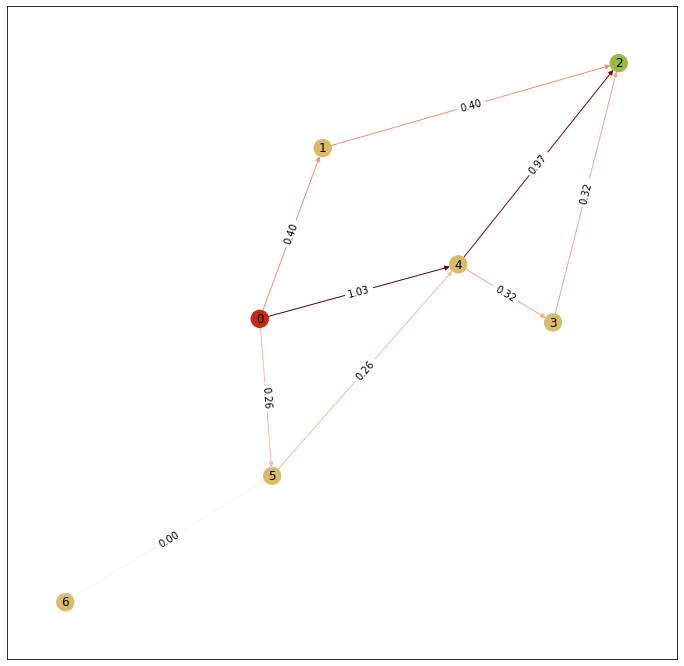

In [39]:
import typing
import networkx as nx
import matplotlib.pyplot as plt
# pos = nx.spring_layout(G)  # positions for all nodes
plt.figure(3,figsize=(12,12)) 
pos =nx.spring_layout(G)

# color of edges and nodes
edges,currents = zip(*nx.get_edge_attributes(G,'current').items())
node_colors = [val for key, val in nx.get_node_attributes(G, 'color').items()]
labels = nx.get_edge_attributes(G,'current')
labels_form = {}
for key, val in labels.items():
    labels_form[key] = "{0:.2f}".format(val)
    
# nx.draw_networkx_nodes(G, pos, node_color=node_colors)
nx.draw_networkx_nodes(G, pos, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=currents, edge_cmap=plt.cm.Reds) # or jet
nx.draw_networkx_labels(G, pos, font_family='sans-serif')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels_form)
plt.savefig("whatever.png")
plt.show()

### Check the correctness of generated solution